## Setup: Install Dependencies

First, we'll ensure all required packages are installed.

In [42]:
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    """Install a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

# List of required packages
required_packages = ["matplotlib", "numpy", "pandas"]

# Install each package if necessary
for package in required_packages:
    install_package(package)

print("All required packages are installed:")
print("✓ matplotlib")
print("✓ numpy")


✓ matplotlib is already installed
✓ numpy is already installed
Installing pandas...
✓ pandas installed successfully
All required packages are installed:
✓ matplotlib
✓ numpy


# Branch and Bound for the Smuggling Route Optimization Problem

This notebook implements a **Branch and Bound** algorithm to solve a complex combinatorial optimization problem that combines aspects of the **Traveling Salesman Problem (TSP)** and the **Knapsack Problem**.

## Problem Overview

A truck is used for smuggling operations across the Uruguay-Brazil border in Rocha (Chuy). The operation involves:
- **Multiple border crossings** between pickup points (suppliers in Brazil) and delivery points (warehouses in Uruguay)
- **Limited truck capacity** for transporting goods
- **Risk accumulation** at each border crossing
- **Profit maximization** from delivered goods

### Key Constraints:
- Each location can only be visited once (except depot)
- Truck has maximum volume capacity
- Each warehouse has maximum storage capacity
- Total accumulated risk must not exceed threshold
- Route must start and end at depot (location 0)

## Formal Problem Definition

### Parameters

- $V_{max}$: Maximum truck capacity (volume)
- $G_k$: Unit profit for product $k$
- $R_{ij}$: Base risk of detection on segment from $i$ to $j$
- $D_{ij}$: Travel distance from $i$ to $j$
- $P$: Set of all route points (suppliers and warehouses)
- $B$: Set of all smuggled products
- $A_{k,i}$: Available quantity of product $k$ at location $i$ (0 for warehouses)
- $R_{max}$: Maximum allowed accumulated risk
- $V_k$: Unit volume of product $k$
- $S_{max}^i$: Maximum storage capacity at warehouse $i$
- $abroad_i \in \{0,1\}$: Binary indicator (1 = supplier, 0 = warehouse)

### Decision Variables

- $z_{ij} \in \{0,1\}$: Binary variable, 1 if truck travels from $i$ to $j$
- $c_{k,i}^+ \in \mathbb{R}_{\geq 0}$: Quantity of product $k$ picked up at location $i$
- $c_{k,i}^- \in \mathbb{R}_{\geq 0}$: Quantity of product $k$ delivered at location $i$
- $q_{k,i} \in \mathbb{R}_{\geq 0}$: Quantity of product $k$ in truck after visiting location $i$

### Objective Function

Maximize total profit from delivered product:

$$\text{maximize } f_0(x) = \sum_{k \in B} \sum_{i \in P} c_{k,i}^- \cdot G_k$$

## `Node` Class

The `Node` class represents a node in the Branch and Bound search tree. Each node corresponds to a partial solution (or complete solution if at a leaf) in the solution space.

### Node Attributes

- **`level`**: Depth in the search tree (number of decisions made)
- **`bound`**: Upper bound on the maximum achievable profit from this node. Used for pruning: if `bound ≤ best_value`, this branch can be discarded.
- **`value`**: Current profit of this partial solution (0 until route is complete)
- **`path`**: List of decisions taken to reach this node (location visited, action type, quantities)
- **`data`**: Dictionary containing the current state:
  - `current_location`: Current position of the truck
  - `current_volume`: Total volume currently in truck (should satisfy $\sum_k q_k \cdot V_k \leq V_{max}$)
  - `travels_from_i_to_j`: Adjacency matrix representing route edges ($z_{ij}$ variables)
  - `items_taken_from_supplier`: Matrix $c_{k,i}^+$ (quantities picked up)
  - `items_left_at_location`: Matrix $c_{k,i}^-$ (quantities delivered)

  - `remaining_stock`: Remaining available stock at each supplierThe `__lt__` method enables priority queue ordering. For maximization problems, nodes with **higher bounds** have higher priority (using `-bound` for min-heap behavior).

  - `items_in_truck`: Current inventory vector ($q_{k,i}$ after location $i$)

### Comparison Operator

In [29]:
from typing import Any, List, Optional
from dataclasses import dataclass
import heapq


@dataclass
class Node:
    """Represents a node in the search tree."""
    level: int  # Depth in the tree
    bound: float  # Upper bound on the optimal solution
    value: float  # Current value of this partial solution
    path: List[Any]  # Decisions made so far
    data: dict  
    
    def __lt__(self, other):
        # For max problems, use -bound; for min problems, use bound
        return self.bound > other.bound  # Assumes maximization



## Auxiliary function `get_visited`

As shown above, the data from the paths taken is stored in a matrix of adjacency `travels_from_i_to_j`, this is done this way because of how the problem was formally defined, this structure is however impractical for some later calculations.

The `get_visited` function receives the aforementioned matrix and returns a set with all visited locations as indexes.

In [30]:
# Auxiliar to find visited locations from adjacency matrix

def get_visited(matrix):
    n = len(matrix)
    indices = set()

    # Check rows
    for row_idx in range(n):
        if 1 in matrix[row_idx]:
            indices.add(row_idx)  # 0-based index

    # Check columns
    for column_idx in range(n):
        if any(matrix[row_idx][column_idx] == 1 for row_idx in range(n)):
            indices.add(column_idx)  # 0-based index

    # Remove depot (0) from visited set - depot can be visited multiple times
    # (start and end of route)
    indices.discard(0)

    return indices

## `BranchAndBound` Class

This class implements the Branch and Bound algorithm for solving the smuggling route optimization problem.

### Algorithm Overview

**Branch and Bound** is an exact optimization method that systematically explores the solution space using:

1. **Branching**: Generating child nodes by making decisions (visit location, pickup/deliver goods)
2. **Bounding**: Computing upper bounds on achievable profit to enable pruning
3. **Pruning**: Discarding branches where `bound ≤ best_value` (cannot improve solution)

### Key Methods

- **`solve()`**: Main algorithm loop using priority queue (heap) to explore most promising nodes first
- **`create_root_node()`**: Initializes search with empty solution at depot
- **`branch(node)`**: Generates child nodes by deciding next location and pickup/delivery actions
- **`compute_bound(node)`**: Calculates optimistic upper bound: `current_profit + value_in_truck + remaining_stock_value`
- **`is_feasible(node)`**: Checks all constraints (capacity, risk, storage limits)
- **`is_complete_solution(node)`**: Checks if route returns to depot
- **`should_explore(node)`**: Pruning condition: `node.bound > best_value`

### Branching Strategy

At each location:
- **Suppliers** (abroad=1): Generate two branches
  - Pick up maximum possible of each good (greedy by profit/volume ratio)
  - Skip location (pickup nothing)
  
- **Warehouses** (abroad=0): Generate two branches
  - Deliver maximum possible respecting warehouse capacity
  - Keep goods in truck (deliver nothing)

**Note**: This greedy branching strategy (max pickup/delivery or nothing) does not guarantee optimality but significantly reduces the branching factor compared to exploring all possible quantity combinations.

### Upper Bound Calculation

The bound is computed optimistically as:

$$bound = \text{profit\_delivered} + \sum_{k} q_k \cdot G_k + \sum_{k,i} A_{k,i}^{remaining} \cdot G_k$$

This assumes:
- All goods currently in truck will be delivered
- All remaining stock can be picked up and delivered
- No capacity or storage constraints bind

This optimism enables effective pruning while guaranteeing no optimal solutions are discarded.

In [3]:

class BranchAndBound:
    """
    Branch and Bound solver for the Smuggling Route Optimization Problem.
    
    Implements exact optimization combining TSP routing with knapsack pickup/delivery decisions.
    """
    
    from typing import List

    def __init__(
        self,
        max_volume: int,                          # V_max: Maximum truck capacity
        unit_profit: List[int],                    # G_k: Unit profit per product k
        risk: List[List[float]],                   # R_ij: Risk on segment i->j
        distance: List[List[int]],                 # D_ij: Distance i->j
        is_abroad: List[int],                      # abroad_i: 1=supplier, 0=warehouse
        stock: List[List[int]],                    # A_k,i: Stock of product k at location i
        volume_per_product: List[int],             # V_k: Unit volume of product k
        max_volume_storage_per_location: List[int], # S_max^i: Warehouse capacity
        max_risk: float                            # R_max: Maximum allowed risk
    ) -> None:
        """
        Initialize the Branch and Bound solver with problem parameters.
        
        Args correspond to formal problem definition parameters (see markdown above).
        """
    
        self.max_volume = max_volume
        self.unit_profit = unit_profit
        self.risk = risk
        self.distance = distance
        self.is_abroad = is_abroad
        self.stock = stock
        self.volume_per_product = volume_per_product
        self.max_volume_storage_per_location = max_volume_storage_per_location
        self.max_risk = max_risk

        self.number_product_types = len(stock)  # Number of different product types
        self.number_locations = len(is_abroad)
        self.best_value = float('-inf') 
        self.best_solution = None
        self.nodes_explored = 0

        
    def solve(self) -> tuple[Optional[Any], float]:
        """
        Main Branch and Bound algorithm.
        
        Returns:
            tuple: (best_solution, best_value)
        """
        # Initialize with root node
        root = self.create_root_node()
        
        # Priority queue for nodes to explore (using heap)
        queue = []
        heapq.heappush(queue, root)
        
        while queue:
            # Get the most promising node
            current_node = heapq.heappop(queue)
            self.nodes_explored += 1
            
            # Prune if bound is worse than best found
            if not self.should_explore(current_node):
                continue
            
            # Check if we have a complete solution
            if self.is_complete_solution(current_node):
                self.update_best_solution(current_node)
                continue
            
            # Branch: generate child nodes
            children = self.branch(current_node)
            
            for child in children:
                # Check feasibility
                if not self.is_feasible(child):
                    continue
                
                # Bound: calculate upper bound
                child.bound = self.compute_bound(child)
                
                # Add to queue if promising
                if self.should_explore(child):
                    heapq.heappush(queue, child)
        
        return self.best_solution, self.best_value

    
    def create_root_node(self) -> Node:
        """
        Create the initial root node of the search tree.
        
        Returns:
            Node: The root node representing the empty solution
        """
        return Node(
            level=0,
            bound=self.compute_initial_bound(),
            value=0,
            path=[],
            data={
                    'current_location': 0,
                    'current_volume': 0,  # Current volume in truck
                    'travels_from_i_to_j': [
                        [0 for destination_idx in range(self.number_locations)]
                        for origin_idx in range(self.number_locations)
                    ],

                    'items_taken_from_supplier': [
                        [0 for location_idx in range(self.number_locations)]
                        for product_type_idx in range(self.number_product_types)
                    ],

                    'items_left_at_location': [
                        [0 for location_idx in range(self.number_locations)]
                        for product_type_idx in range(self.number_product_types)
                    ],
                    
                    'remaining_stock': [
                        [self.stock[product_type_idx][location_idx] for location_idx in range(self.number_locations)]
                        for product_type_idx in range(self.number_product_types)
                    ],
                    
                    # Track what's currently in the truck for each item
                    'items_in_truck': [0] * self.number_product_types
                }
        )
        
    def branch(self, node: Node) -> List[Node]:
        """
        Generate child nodes by branching from the current node.
        
        The decision has two parts:
        1. Choose next location to visit
        2. If location is abroad (supplier): decide how much of each item to pick up
           If location is storage: decide how much of each item to leave
        
        Key insight: When picking up at a supplier, we DON'T know yet if items will be
        delivered. The bound provides optimistic guidance, but actual profit is only
        realized when items are confirmed left at storage in a complete solution.
        
        Args:
            node: Current node to branch from
            
        Returns:
            List[Node]: List of child nodes representing different decisions
        
        """
        
        children = []
        current_location = node.data['current_location']
        visited = get_visited(node.data['travels_from_i_to_j'])

        for next_location in range(self.number_locations):
            # Allow returning to depot (location 0) or visiting unvisited locations
            if next_location == 0:
                # Can return to depot from anywhere except depot itself
                # Depot is a storage location, so branch for dropoff decisions
                if current_location != 0:
                    children.extend(self._branch_storage(node, current_location, next_location))
            elif next_location != current_location and next_location not in visited:
                if self.is_abroad[next_location] == 1:
                    # Supplier location: generate children for different pickup combinations
                    children.extend(self._branch_supplier(node, current_location, next_location))
                else:
                    # Storage location: generate children for different dropoff combinations
                    children.extend(self._branch_storage(node, current_location, next_location))
        
        return children
    
    def _branch_supplier(self, node: Node, current_location: int, next_location: int) -> List[Node]:
        """
        Branch at a supplier location: decide how much of each item to pick up.
        
        Important: At this point, we're making a pickup decision WITHOUT knowing for certain
        if these items will be delivered. The bound calculation provides optimistic guidance,
        but the actual profit depends on future decisions (whether to drop off or not).
        
        Args:
            node: Current node
            current_location: Current location index
            next_location: Supplier location index
            
        Returns:
            List[Node]: Child nodes with different pickup combinations
        """
        children = []
        
        # Option 1: Try to pick up as much as possible (greedy approach)
        new_data = self._create_child_data(node, current_location, next_location)
        current_volume = node.data['current_volume']
        remaining_capacity = self.max_volume - current_volume
        
        pickup_quantities = [0] * self.number_product_types
        
        for product_type_idx in range(self.number_product_types):
            available = node.data['remaining_stock'][product_type_idx][next_location]
            item_volume = self.volume_per_product[product_type_idx]
            
            if item_volume > 0:
                # Pick up as many as possible
                max_pickup = min(available, remaining_capacity // item_volume)
                pickup_quantities[product_type_idx] = max_pickup
                
                new_data['items_taken_from_supplier'][product_type_idx][next_location] += max_pickup
                new_data['remaining_stock'][product_type_idx][next_location] -= max_pickup
                new_data['items_in_truck'][product_type_idx] += max_pickup
                new_data['current_volume'] += max_pickup * item_volume
                remaining_capacity -= max_pickup * item_volume
        
        # Value remains 0 because we don't know yet if these will be delivered
        child_node = Node(
            level=node.level + 1,
            bound=0,
            value=0,  # No profit from just picking up
            path=node.path + [(next_location, 'pickup', pickup_quantities)],
            data=new_data
        )
        children.append(child_node)
        
        # Option 2: Skip this supplier (pick up nothing)
        new_data_skip = self._create_child_data(node, current_location, next_location)
        child_node_skip = Node(
            level=node.level + 1,
            bound=0,
            value=0,
            path=node.path + [(next_location, 'skip', [0] * self.number_product_types)],
            data=new_data_skip
        )
        children.append(child_node_skip)
        
        return children
    
    def _branch_storage(self, node: Node, current_location: int, next_location: int) -> List[Node]:
        """
        Branch at a storage location: decide how much of each item to leave.
        
        This is where uncertainty gets resolved: by choosing to drop off items here,
        we're committing that these items will contribute to profit (assuming we
        complete the route successfully).
        
        Args:
            node: Current node
            current_location: Current location index
            next_location: Storage location index
            
        Returns:
            List[Node]: Child nodes with different dropoff combinations
        """
        children = []
        
        # What we're currently carrying
        current_items = node.data['items_in_truck'].copy()
        
        # Check how much space is available at this storage location
        storage_capacity = self.max_volume_storage_per_location[next_location]
        current_storage_volume = sum(
            node.data['items_left_at_location'][product_type_idx][next_location] * self.volume_per_product[product_type_idx]
            for product_type_idx in range(self.number_product_types)
        )
        available_storage = storage_capacity - current_storage_volume
        
        # Option 1: Drop off as much as possible (respecting storage capacity)
        new_data = self._create_child_data(node, current_location, next_location)
        dropoff_quantities = [0] * self.number_product_types
        remaining_storage = available_storage
        
        for product_type_idx in range(self.number_product_types):
            carrying = current_items[product_type_idx]
            if carrying > 0:
                item_volume = self.volume_per_product[product_type_idx]
                # Drop off as many as possible given storage capacity
                max_dropoff = min(carrying, remaining_storage // item_volume) if item_volume > 0 else carrying
                dropoff_quantities[product_type_idx] = max_dropoff
                
                new_data['items_left_at_location'][product_type_idx][next_location] += max_dropoff
                new_data['items_in_truck'][product_type_idx] -= max_dropoff
                new_data['current_volume'] -= max_dropoff * item_volume
                remaining_storage -= max_dropoff * item_volume
        
        # Only create dropoff node if we're actually dropping something off
        if any(q > 0 for q in dropoff_quantities):
            child_node = Node(
                level=node.level + 1,
                bound=0,
                value=0,  # Profit calculated only at completion
                path=node.path + [(next_location, 'dropoff', dropoff_quantities)],
                data=new_data
            )
            children.append(child_node)
        
        # Option 2: Keep everything (just visit, don't drop off)
        # This is a valid decision: we visited but chose not to deliver here
        new_data_keep = self._create_child_data(node, current_location, next_location)
        child_node_keep = Node(
            level=node.level + 1,
            bound=0,
            value=0,
            path=node.path + [(next_location, 'keep', [0] * self.number_product_types)],
            data=new_data_keep
        )
        children.append(child_node_keep)
        
        # Option 3: Partial dropoff (can be expanded for more granular decisions)
        # For now, we keep it simple with all-or-nothing
        
        return children
    
    def _create_child_data(self, node: Node, current_location: int, next_location: int) -> dict:
        """
        Create a copy of node data with updated travel information.
        
        Args:
            node: Parent node
            current_location: Current location
            next_location: Next location
            
        Returns:
            dict: New data dictionary for child node
        """
        new_data = {
            'current_location': next_location,
            'current_volume': node.data['current_volume'],
            'travels_from_i_to_j': [row.copy() for row in node.data['travels_from_i_to_j']],
            'items_taken_from_supplier': [row.copy() for row in node.data['items_taken_from_supplier']],
            'items_left_at_location': [row.copy() for row in node.data['items_left_at_location']],
            'remaining_stock': [row.copy() for row in node.data['remaining_stock']],
            'items_in_truck': node.data['items_in_truck'].copy()
        }
        
        # Update travels
        new_data['travels_from_i_to_j'][current_location][next_location] = 1
        
        return new_data
    
    def _calculate_total_profit(self, node: Node) -> float:
        """
        Calculate the total profit based on items left at storage locations.
        Only items that remain at storage locations at the end generate profit.
        
        This is called ONLY when we have a complete solution (returned to depot).
        At that point, we know with certainty which items were delivered.
        
        Args:
            node: Node to calculate profit for
            
        Returns:
            float: Total profit value
        """
        total_profit = 0.0
        
        # Only count items left at storage locations (is_abroad == 0)
        for location_idx in range(self.number_locations):
            if self.is_abroad[location_idx] == 0:  # Storage location
                for product_type_idx in range(self.number_product_types):
                    quantity = node.data['items_left_at_location'][product_type_idx][location_idx]
                    # Match product_type_idx directly with unit_profit
                    if product_type_idx < len(self.unit_profit):
                        profit_per_unit = self.unit_profit[product_type_idx]
                        total_profit += quantity * profit_per_unit
        
        return total_profit

    
    def is_feasible(self, node: Node) -> bool:
        """
        Check if the node represents a feasible partial solution.
        
        Args:
            node: Node to check
            
        Returns:
            bool: True if feasible, False otherwise
        """
        # Check volume constraint
        if node.data['current_volume'] > self.max_volume:
            return False
        
        # Verify items_in_truck matches current_volume
        calculated_volume = sum(
            node.data['items_in_truck'][product_type_idx] * self.volume_per_product[product_type_idx]
            for product_type_idx in range(self.number_product_types)
        )
        if abs(calculated_volume - node.data['current_volume']) > 0.01:
            return False
        
        # Check storage capacity at each location
        for location_idx in range(self.number_locations):
            if self.is_abroad[location_idx] == 0:  # Storage location
                total_volume = sum(
                    node.data['items_left_at_location'][product_type_idx][location_idx] * 
                    self.volume_per_product[product_type_idx]
                    for product_type_idx in range(self.number_product_types)
                )
                if total_volume > self.max_volume_storage_per_location[location_idx]:
                    return False

        # Check risk constraint - calculate cumulative risk correctly
        # Risk should be: product of (1 - risk[i][j]) for each edge traversed
        cumulative_safety = 1.0
        for origin_idx in range(self.number_locations):
            for destination_idx in range(self.number_locations):
                if node.data['travels_from_i_to_j'][origin_idx][destination_idx] == 1:
                    cumulative_safety *= (1 - self.risk[origin_idx][destination_idx])
        
        total_risk = 1 - cumulative_safety
        
        if total_risk > self.max_risk:
            return False
        
        return True
        
    def compute_initial_bound(self) -> float:
        """Compute initial optimistic bound."""
        # Simple upper bound: sum of all possible profits
        return sum(sum(row) for row in self.stock) * max(self.unit_profit)
    
    def compute_bound(self, node: Node) -> float:
        """
        Compute an optimistic bound for the node.
        
        This is KEY to handling uncertainty: the bound assumes the BEST CASE scenario
        where all picked-up items eventually get delivered, and all remaining stock
        can still be picked up and delivered.
        
        Args:
            node: Node to compute bound for
            
        Returns:
            float: The computed bound (optimistic estimate)
        """
        # Profit from items already delivered (certain)
        current_profit = self._calculate_total_profit(node)
        
        # Optimistic value from items currently in truck
        # (assumes they WILL be delivered)
        truck_value = 0
        for product_type_idx in range(self.number_product_types):
            if product_type_idx < len(self.unit_profit):
                truck_value += node.data['items_in_truck'][product_type_idx] * self.unit_profit[product_type_idx]
        
        # Optimistic value from remaining stock
        # (assumes we CAN pick up and deliver everything)
        remaining_value = 0
        for product_type_idx in range(self.number_product_types):
            remaining = sum(node.data['remaining_stock'][product_type_idx])
            if product_type_idx < len(self.unit_profit):
                profit_per_unit = self.unit_profit[product_type_idx]
                remaining_value += remaining * profit_per_unit
        
        return current_profit + truck_value + remaining_value
    
    def is_complete_solution(self, node: Node) -> bool:
        """
        Check if the node represents a complete solution.
        
        Args:
            node: Node to check
            
        Returns:
            bool: True if complete, False otherwise
        """
        # Complete when truck is back at depot (location 0) 
        # and has visited at least some locations
        # No need to check if truck is empty - profit is based on deliveries made
        return (node.data['current_location'] == 0 and 
                node.level > 0)
    
    def should_explore(self, node: Node) -> bool:
        """
        Determine if a node should be explored (pruning condition).
        
        Args:
            node: Node to check
            
        Returns:
            bool: True if should explore, False if should prune
        """
        # For maximization
        return node.bound > self.best_value
    
    def update_best_solution(self, node: Node) -> None:
        """
        Update the best solution found so far if this node is better.
        
        This is where uncertainty is RESOLVED: we have a complete route,
        we know exactly which items were delivered, so we can calculate
        the actual profit.
        
        Args:
            node: Complete solution node to compare
        """
        # Calculate actual profit from items left at storage
        actual_profit = self._calculate_total_profit(node)
        
        if actual_profit > self.best_value:  # For maximization
            self.best_value = actual_profit
            self.best_solution = node.path.copy()



## Test Instance 1: Hand-Crafted Example

The following cells define a small problem instance for testing the Branch and Bound implementation.

**Problem Setup:**
- 6 locations (1 depot + 5 points)
- 12 different goods
- Truck capacity: 1000 volume units
- Maximum risk threshold: 0.9

In [32]:
max_volume = 1000

unit_profit = [20, 5, 10, 40, 15, 25, 30, 12, 18, 22, 14, 28]

risk = [
    [0.04, 0.028, 0.036, 0.03, 0.034, 0.032],
    [0.028, 0.04, 0.026, 0.034, 0.03, 0.036],
    [0.036, 0.026, 0.04, 0.032, 0.028, 0.038],
    [0.03, 0.034, 0.032, 0.04, 0.026, 0.036],
    [0.034, 0.03, 0.028, 0.026, 0.04, 0.032],
    [0.032, 0.036, 0.038, 0.036, 0.032, 0.04]
]

distance = [
    [5, 10, 15, 20, 25, 30],
    [10, 5, 20, 15, 30, 25],
    [15, 20, 5, 30, 10, 35],
    [20, 15, 30, 5, 25, 10],
    [25, 30, 10, 25, 5, 15],
    [30, 25, 35, 10, 15, 5]
]

is_abroad = [0, 1, 0, 1, 0, 1]


# Available stock for each type of product, rows represent products and columns represent different suppliers
# Odd columns are all 0 since they represent storages, not suppliers. As is_abroad indicates.
stock = [
    [0, 230, 0, 75, 0, 95],
    [0, 105, 0, 155, 0, 175],
    [0, 185, 0, 130, 0, 115],
    [0, 165, 0, 110, 0, 135],
    [0, 140, 0, 205, 0, 160],
    [0, 175, 0, 135, 0, 90],
    [0, 90, 0, 120, 0, 170],
    [0, 220, 0, 180, 0, 150],
    [0, 135, 0, 155, 0, 175],
    [0, 115, 0, 195, 0, 145],
    [0, 150, 0, 130, 0, 100],
    [0, 120, 0, 140, 0, 200]
]

volume_per_product = [10, 20, 15, 25, 30, 12, 18, 22, 14, 28, 16, 24] 

# Maximum storage capacity per location (0 for suppliers)
max_volume_storage_per_location = [3000, 0, 1500, 0, 500, 0]

max_risk = 0.3

problem = BranchAndBound(
    max_volume,
    unit_profit,
    risk,
    distance,
    is_abroad,
    stock,
    volume_per_product,
    max_volume_storage_per_location,
    max_risk
)

best_solution, best_value = problem.solve()
print("Best Value:", best_value)
print("Best Solution Path:", best_solution)

Best Value: 4930.0
Best Solution Path: [(5, 'pickup', [95, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (4, 'dropoff', [50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (3, 'pickup', [51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (2, 'dropoff', [96, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (1, 'pickup', [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (0, 'dropoff', [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


## Test Instance 2-5: Edge Cases

The following cells test various edge cases to validate the algorithm's robustness:
- **Test 2**: Simplest case (single supplier, single item)
- **Test 3**: No feasible solution (excessive risk)
- **Test 4**: Multiple suppliers and warehouses
- **Test 5**: Tight capacity constraints

In [33]:
# Test Case 1: Original problem
print("=" * 80)
print("TEST CASE 1: Original Problem")
print("=" * 80)

problem1 = BranchAndBound(
    max_volume,
    unit_profit,
    risk,
    distance,
    is_abroad,
    stock,
    volume_per_product,
    max_volume_storage_per_location,
    max_risk
)

best_solution1, best_value1 = problem1.solve()
print(f"Nodes explored: {problem1.nodes_explored}")
print(f"Best Value: {best_value1}")
print(f"Best Solution Path: {best_solution1}")
print()

TEST CASE 1: Original Problem
Nodes explored: 10224
Best Value: 4930.0
Best Solution Path: [(5, 'pickup', [95, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (4, 'dropoff', [50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (3, 'pickup', [51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (2, 'dropoff', [96, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (1, 'pickup', [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (0, 'dropoff', [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

Nodes explored: 10224
Best Value: 4930.0
Best Solution Path: [(5, 'pickup', [95, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (4, 'dropoff', [50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (3, 'pickup', [51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (2, 'dropoff', [96, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (1, 'pickup', [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (0, 'dropoff', [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]



In [34]:
# Test Case 2: Single supplier, single item
print("=" * 80)
print("TEST CASE 2: Single Supplier, Single Item (Simplest Case)")
print("=" * 80)

test2_stock = [[0, 100, 0, 0, 0, 0]]  # Only 1 product, 100 units at location 1
test2_volume_per_product = [10]
test2_unit_profit = [50]

problem2 = BranchAndBound(
    max_volume=1000,
    unit_profit=test2_unit_profit,
    risk=risk,
    distance=distance,
    is_abroad=is_abroad,
    stock=test2_stock,
    volume_per_product=test2_volume_per_product,
    max_volume_storage_per_location=max_volume_storage_per_location,
    max_risk=max_risk
)

best_solution2, best_value2 = problem2.solve()
print(f"Nodes explored: {problem2.nodes_explored}")
print(f"Best Value: {best_value2}")
print(f"Expected: 100 units * 50 profit = 5000")
print(f"Best Solution Path: {best_solution2}")
print()

TEST CASE 2: Single Supplier, Single Item (Simplest Case)
Nodes explored: 156
Best Value: 5000.0
Expected: 100 units * 50 profit = 5000
Best Solution Path: [(5, 'skip', [0]), (1, 'pickup', [100]), (4, 'keep', [0]), (3, 'skip', [0]), (2, 'keep', [0]), (0, 'dropoff', [100])]



In [35]:
# Test Case 3: Volume constraint test - truck can't carry everything
print("=" * 80)
print("TEST CASE 3: Volume Constraint (Truck Too Small)")
print("=" * 80)

test3_stock = [
    [0, 1000, 0, 0, 0, 0],  # Product 0: 1000 units, volume 10 each
    [0, 1000, 0, 0, 0, 0]   # Product 1: 1000 units, volume 20 each
]
test3_volume_per_product = [10, 20]
test3_unit_profit = [100, 50]  # Product 0 is more profitable

problem3 = BranchAndBound(
    max_volume=1000,  # Can only fit 100 of product 0 OR 50 of product 1
    unit_profit=test3_unit_profit,
    risk=risk,
    distance=distance,
    is_abroad=is_abroad,
    stock=test3_stock,
    volume_per_product=test3_volume_per_product,
    max_volume_storage_per_location=max_volume_storage_per_location,
    max_risk=max_risk
)

best_solution3, best_value3 = problem3.solve()
print(f"Nodes explored: {problem3.nodes_explored}")
print(f"Best Value: {best_value3}")
print(f"Expected: Should pick product 0 (100 units * 100 = 10000)")
print(f"Best Solution Path: {best_solution3}")
print()

TEST CASE 3: Volume Constraint (Truck Too Small)
Nodes explored: 6650
Best Value: 10000.0
Expected: Should pick product 0 (100 units * 100 = 10000)
Best Solution Path: [(5, 'skip', [0, 0]), (1, 'pickup', [100, 0]), (4, 'keep', [0, 0]), (3, 'skip', [0, 0]), (2, 'keep', [0, 0]), (0, 'dropoff', [100, 0])]



In [36]:
# Test Case 4: Storage capacity constraint - need to use multiple storage locations
print("=" * 80)
print("TEST CASE 4: Storage Capacity Constraint")
print("=" * 80)

test4_stock = [[0, 500, 0, 0, 0, 0]]  # 500 units at supplier 1
test4_volume_per_product = [10]  # Each unit is 10 volume
test4_unit_profit = [20]
test4_storage_capacity = [1000, 0, 1000, 0, 1000, 0]  # Each storage holds only 100 units

problem4 = BranchAndBound(
    max_volume=5000,  # Truck can hold all 500 units
    unit_profit=test4_unit_profit,
    risk=risk,
    distance=distance,
    is_abroad=is_abroad,
    stock=test4_stock,
    volume_per_product=test4_volume_per_product,
    max_volume_storage_per_location=test4_storage_capacity,
    max_risk=max_risk
)

best_solution4, best_value4 = problem4.solve()
print(f"Nodes explored: {problem4.nodes_explored}")
print(f"Best Value: {best_value4}")
print(f"Expected: 100 units at location 0 = 2000 profit")
print(f"Best Solution Path: {best_solution4}")
print()

TEST CASE 4: Storage Capacity Constraint
Nodes explored: 7390
Best Value: 6000.0
Expected: 100 units at location 0 = 2000 profit
Best Solution Path: [(5, 'skip', [0]), (1, 'pickup', [500]), (4, 'dropoff', [100]), (3, 'pickup', [0]), (2, 'dropoff', [100]), (0, 'dropoff', [100])]



In [37]:
# Test Case 5: Risk constraint test - only one safe route available
print("=" * 80)
print("TEST CASE 5: Risk Constraint")
print("=" * 80)

# Create a risk matrix where only route 0->1->0 is safe
# Route: depot -> supplier 1 -> depot
# Risk: (1 - 0.03) * (1 - 0.03) = 0.9409, so cumulative risk = 1 - 0.9409 = 0.0591 < 0.1
test5_risk = [
    [0.04, 0.03, 0.5, 0.5, 0.5, 0.5],   # Low risk to location 1 only
    [0.03, 0.04, 0.5, 0.5, 0.5, 0.5],   # Low risk back to depot
    [0.5, 0.5, 0.04, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.04, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.04, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.04]
]

test5_stock = [
    [0, 100, 0, 100, 0, 100],  # Stock at all suppliers, but only location 1 is safe
]
test5_volume_per_product = [10]
test5_unit_profit = [50]

problem5 = BranchAndBound(
    max_volume=10000,
    unit_profit=test5_unit_profit,
    risk=test5_risk,
    distance=distance,
    is_abroad=is_abroad,
    stock=test5_stock,
    volume_per_product=test5_volume_per_product,
    max_volume_storage_per_location=max_volume_storage_per_location,
    max_risk=0.1  # Low risk tolerance - only route to location 1 is safe
)

best_solution5, best_value5 = problem5.solve()
print(f"Nodes explored: {problem5.nodes_explored}")
print(f"Best Value: {best_value5}")
print(f"Expected: Should visit supplier 1 only (100 * 50 = 5000)")
print(f"Route risk: 0->1->0 = (1-0.03)*(1-0.03) = 0.9409, cumulative risk = 0.0591")
print(f"Best Solution Path: {best_solution5}")
print()

TEST CASE 5: Risk Constraint
Nodes explored: 6
Best Value: 5000.0
Expected: Should visit supplier 1 only (100 * 50 = 5000)
Route risk: 0->1->0 = (1-0.03)*(1-0.03) = 0.9409, cumulative risk = 0.0591
Best Solution Path: [(1, 'pickup', [100]), (0, 'dropoff', [100])]



In [38]:
# Test Case 6: Empty problem - no stock available
print("=" * 80)
print("TEST CASE 6: Empty Problem (No Stock)")
print("=" * 80)

test6_stock = [
    [0, 0, 0, 0, 0, 0],  # No stock anywhere
]
test6_volume_per_product = [10]
test6_unit_profit = [50]

problem6 = BranchAndBound(
    max_volume=1000,
    unit_profit=test6_unit_profit,
    risk=risk,
    distance=distance,
    is_abroad=is_abroad,
    stock=test6_stock,
    volume_per_product=test6_volume_per_product,
    max_volume_storage_per_location=max_volume_storage_per_location,
    max_risk=max_risk
)

best_solution6, best_value6 = problem6.solve()
print(f"Nodes explored: {problem6.nodes_explored}")
print(f"Best Value: {best_value6}")
print(f"Expected: 0 (no stock to pick up)")
print(f"Best Solution Path: {best_solution6}")
print()

TEST CASE 6: Empty Problem (No Stock)
Nodes explored: 123
Best Value: 0.0
Expected: 0 (no stock to pick up)
Best Solution Path: [(1, 'pickup', [0]), (5, 'skip', [0]), (4, 'keep', [0]), (3, 'pickup', [0]), (2, 'keep', [0]), (0, 'keep', [0])]



In [39]:
# Test Case 7: Multiple suppliers, verify it picks the most profitable
print("=" * 80)
print("TEST CASE 7: Multiple Suppliers (Profit Optimization)")
print("=" * 80)

test7_stock = [
    [0, 100, 0, 100, 0, 100],  # Product 0: low profit
    [0, 100, 0, 100, 0, 100],  # Product 1: medium profit  
    [0, 100, 0, 100, 0, 100],  # Product 2: high profit
]
test7_volume_per_product = [10, 10, 10]  # All same volume
test7_unit_profit = [5, 20, 100]  # Product 2 is most profitable

problem7 = BranchAndBound(
    max_volume=1000,  # Can hold 100 units total
    unit_profit=test7_unit_profit,
    risk=risk,
    distance=distance,
    is_abroad=is_abroad,
    stock=test7_stock,
    volume_per_product=test7_volume_per_product,
    max_volume_storage_per_location=max_volume_storage_per_location,
    max_risk=max_risk
)

best_solution7, best_value7 = problem7.solve()
print(f"Nodes explored: {problem7.nodes_explored}")
print(f"Best Value: {best_value7}")
print(f"Expected: Should pick product 2 (100 units * 100 = 10000)")
print(f"Best Solution Path: {best_solution7}")
print()

TEST CASE 7: Multiple Suppliers (Profit Optimization)
Nodes explored: 10224
Best Value: 1250.0
Expected: Should pick product 2 (100 units * 100 = 10000)
Best Solution Path: [(5, 'pickup', [100, 0, 0]), (4, 'dropoff', [50, 0, 0]), (3, 'pickup', [50, 0, 0]), (2, 'dropoff', [100, 0, 0]), (1, 'pickup', [100, 0, 0]), (0, 'dropoff', [100, 0, 0])]



# Performance Tests

The following code cells show both time and spacial performance test for increasing size random problems.

In [40]:
import time
import tracemalloc
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Tuple
import json

# ============================================================================
# RANDOM INSTANCE GENERATOR
# ============================================================================

def generate_random_instance(
    n_locations: int,
    n_items: int,
    seed: int = None
) -> Dict:
    """
    Generates a random instance of the smuggling problem.
    
    Args:
        n_locations: Total number of locations (including depot)
        n_items: Number of product types
        seed: Seed for reproducibility
    
    Returns:
        Dictionary with all problem parameters
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Ensure we have at least depot + 1 supplier + 1 storage
    assert n_locations >= 3, "Need at least 3 locations"
    
    # Depot is always location 0 (storage)
    # Alternate suppliers and storages for the rest
    is_abroad = [0]  # Depot is storage
    for i in range(1, n_locations):
        is_abroad.append(1 if i % 2 == 1 else 0)  # Odd=supplier, Even=storage
    
    n_suppliers = sum(is_abroad)
    n_storages = n_locations - n_suppliers
    
    # Problem parameters
    max_volume = random.randint(800, 1200)
    
    # Unit profits (more varied)
    unit_profit = [random.randint(10, 100) for _ in range(n_items)]
    
    # Volumes per product (inversely proportional to profit for complexity)
    volume_per_product = []
    for profit in unit_profit:
        # Higher profit → tends to higher volume (interesting trade-off)
        base_volume = random.randint(5, 30)
        volume_per_product.append(base_volume)
    
    # Risk matrix (symmetric, low values)
    risk = [[0.0 for _ in range(n_locations)] for _ in range(n_locations)]
    for i in range(n_locations):
        for j in range(i+1, n_locations):
            # Higher risk in border crossings (supplier <-> storage)
            if is_abroad[i] != is_abroad[j]:
                base_risk = random.uniform(0.02, 0.08)
            else:
                base_risk = random.uniform(0.01, 0.04)
            
            risk[i][j] = base_risk
            risk[j][i] = base_risk
    
    # Distance matrix (symmetric)
    distance = [[0 for _ in range(n_locations)] for _ in range(n_locations)]
    for i in range(n_locations):
        for j in range(i+1, n_locations):
            dist = random.randint(5, 50)
            distance[i][j] = dist
            distance[j][i] = dist
    
    # Stock at suppliers (0 at storages)
    stock = []
    for k in range(n_items):
        item_stock = []
        for i in range(n_locations):
            if is_abroad[i] == 1:  # Supplier
                # Variable but sufficient stock
                item_stock.append(random.randint(50, 200))
            else:  # Storage
                item_stock.append(0)
        stock.append(item_stock)
    
    # Storage capacity (only for storages)
    max_volume_storage_per_location = []
    for i in range(n_locations):
        if is_abroad[i] == 0:  # Storage
            if i == 0:  # Depot has larger capacity
                capacity = random.randint(2000, 4000)
            else:
                capacity = random.randint(500, 1500)
        else:  # Supplier
            capacity = 0
        max_volume_storage_per_location.append(capacity)
    
    # Maximum acceptable risk
    max_risk = random.uniform(0.15, 0.35)
    
    return {
        'max_volume': max_volume,
        'unit_profit': unit_profit,
        'risk': risk,
        'distance': distance,
        'is_abroad': is_abroad,
        'stock': stock,
        'volume_per_product': volume_per_product,
        'max_volume_storage_per_location': max_volume_storage_per_location,
        'max_risk': max_risk,
        'n_locations': n_locations,
        'n_items': n_items,
        'n_suppliers': n_suppliers,
        'n_storages': n_storages
    }


# ============================================================================
# EXPERIMENT 1: SCALABILITY BY NUMBER OF LOCATIONS
# ============================================================================

def experiment_scaling_locations(
    location_sizes: List[int],
    n_items: int = 5,
    trials_per_size: int = 3,
    timeout_seconds: float = 60.0
) -> Dict:
    """
    Experiments with increasing instance sizes in locations.
    
    Args:
        location_sizes: List of sizes to test (e.g., [3, 5, 7, 9])
        n_items: Fixed number of product types
        trials_per_size: Repetitions per size to average
        timeout_seconds: Maximum time per instance
    
    Returns:
        Dictionary with aggregated results
    """
    results = {
        'location_sizes': [],
        'avg_time': [],
        'std_time': [],
        'avg_memory_mb': [],
        'std_memory_mb': [],
        'avg_nodes_explored': [],
        'std_nodes_explored': [],
        'avg_value': [],
        'timeout_count': []
    }
    
    print("=" * 80)
    print("EXPERIMENT 1: Scalability by Number of Locations")
    print("=" * 80)
    print(f"Sizes to test: {location_sizes}")
    print(f"Fixed items: {n_items}")
    print(f"Trials per size: {trials_per_size}")
    print(f"Timeout: {timeout_seconds}s")
    print()
    
    for size in location_sizes:
        print(f"\n--- Testing {size} locations ---")
        
        times = []
        memories = []
        nodes = []
        values = []
        timeouts = 0
        
        for trial in range(trials_per_size):
            print(f"  Trial {trial + 1}/{trials_per_size}...", end=" ")
            
            # Generate random instance
            instance = generate_random_instance(
                n_locations=size,
                n_items=n_items,
                seed=42 + size * 100 + trial  # Reproducible but varied
            )
            
            # Create problem
            problem = BranchAndBound(
                instance['max_volume'],
                instance['unit_profit'],
                instance['risk'],
                instance['distance'],
                instance['is_abroad'],
                instance['stock'],
                instance['volume_per_product'],
                instance['max_volume_storage_per_location'],
                instance['max_risk']
            )
            
            # Measure time and memory
            tracemalloc.start()
            start_time = time.time()
            
            try:
                # Add simple timeout
                solution, value = problem.solve()
                elapsed_time = time.time() - start_time
                
                if elapsed_time > timeout_seconds:
                    print("TIMEOUT")
                    timeouts += 1
                    continue
                
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                
                memory_mb = peak / 1024 / 1024  # Convert to MB
                
                times.append(elapsed_time)
                memories.append(memory_mb)
                nodes.append(problem.nodes_explored)
                values.append(value)
                
                print(f"✓ {elapsed_time:.2f}s, {memory_mb:.1f}MB, {problem.nodes_explored} nodes")
                
            except Exception as e:
                print(f"ERROR: {str(e)}")
                tracemalloc.stop()
                continue
        
        # Calculate statistics
        if times:
            results['location_sizes'].append(size)
            results['avg_time'].append(np.mean(times))
            results['std_time'].append(np.std(times))
            results['avg_memory_mb'].append(np.mean(memories))
            results['std_memory_mb'].append(np.std(memories))
            results['avg_nodes_explored'].append(np.mean(nodes))
            results['std_nodes_explored'].append(np.std(nodes))
            results['avg_value'].append(np.mean(values))
            results['timeout_count'].append(timeouts)
            
            print(f"\n  Average: {np.mean(times):.2f}s ± {np.std(times):.2f}s")
            print(f"  Memory: {np.mean(memories):.1f}MB ± {np.std(memories):.1f}MB")
            print(f"  Nodes: {np.mean(nodes):.0f} ± {np.std(nodes):.0f}")
        else:
            print(f"\n  ⚠ No trial completed for size {size}")
    
    return results


# ============================================================================
# EXPERIMENT 2: SCALABILITY BY NUMBER OF PRODUCTS
# ============================================================================

def experiment_scaling_items(
    item_sizes: List[int],
    n_locations: int = 6,
    trials_per_size: int = 3,
    timeout_seconds: float = 60.0
) -> Dict:
    """
    Experiments with increasing instance sizes in number of items.
    
    Args:
        item_sizes: List of item counts to test (e.g., [3, 5, 8, 12])
        n_locations: Fixed number of locations
        trials_per_size: Repetitions per size to average
        timeout_seconds: Maximum time per instance
    
    Returns:
        Dictionary with aggregated results
    """
    results = {
        'item_sizes': [],
        'avg_time': [],
        'std_time': [],
        'avg_memory_mb': [],
        'std_memory_mb': [],
        'avg_nodes_explored': [],
        'std_nodes_explored': [],
        'avg_value': [],
        'timeout_count': []
    }
    
    print("\n" + "=" * 80)
    print("EXPERIMENT 2: Scalability by Number of Items")
    print("=" * 80)
    print(f"Sizes to test: {item_sizes}")
    print(f"Fixed locations: {n_locations}")
    print(f"Trials per size: {trials_per_size}")
    print(f"Timeout: {timeout_seconds}s")
    print()
    
    for size in item_sizes:
        print(f"\n--- Testing {size} items ---")
        
        times = []
        memories = []
        nodes = []
        values = []
        timeouts = 0
        
        for trial in range(trials_per_size):
            print(f"  Trial {trial + 1}/{trials_per_size}...", end=" ")
            
            # Generate random instance
            instance = generate_random_instance(
                n_locations=n_locations,
                n_items=size,
                seed=42 + size * 100 + trial
            )
            
            # Create problem
            problem = BranchAndBound(
                instance['max_volume'],
                instance['unit_profit'],
                instance['risk'],
                instance['distance'],
                instance['is_abroad'],
                instance['stock'],
                instance['volume_per_product'],
                instance['max_volume_storage_per_location'],
                instance['max_risk']
            )
            
            # Measure time and memory
            tracemalloc.start()
            start_time = time.time()
            
            try:
                solution, value = problem.solve()
                elapsed_time = time.time() - start_time
                
                if elapsed_time > timeout_seconds:
                    print("TIMEOUT")
                    timeouts += 1
                    tracemalloc.stop()
                    continue
                
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                
                memory_mb = peak / 1024 / 1024
                
                times.append(elapsed_time)
                memories.append(memory_mb)
                nodes.append(problem.nodes_explored)
                values.append(value)
                
                print(f"✓ {elapsed_time:.2f}s, {memory_mb:.1f}MB, {problem.nodes_explored} nodes")
                
            except Exception as e:
                print(f"ERROR: {str(e)}")
                tracemalloc.stop()
                continue
        
        # Calculate statistics
        if times:
            results['item_sizes'].append(size)
            results['avg_time'].append(np.mean(times))
            results['std_time'].append(np.std(times))
            results['avg_memory_mb'].append(np.mean(memories))
            results['std_memory_mb'].append(np.std(memories))
            results['avg_nodes_explored'].append(np.mean(nodes))
            results['std_nodes_explored'].append(np.std(nodes))
            results['avg_value'].append(np.mean(values))
            results['timeout_count'].append(timeouts)
            
            print(f"\n  Average: {np.mean(times):.2f}s ± {np.std(times):.2f}s")
            print(f"  Memory: {np.mean(memories):.1f}MB ± {np.std(memories):.1f}MB")
            print(f"  Nodes: {np.mean(nodes):.0f} ± {np.std(nodes):.0f}")
        else:
            print(f"\n  ⚠ No trial completed for size {size}")
    
    return results


# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_scalability_results(
    results_locations: Dict,
    results_items: Dict,
    save_path: str = None
):
    """
    Creates comprehensive visualizations of scalability experiments.
    
    Args:
        results_locations: Results from location scaling experiment
        results_items: Results from item scaling experiment
        save_path: Optional path to save figure
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Branch and Bound Scalability Analysis', fontsize=16, fontweight='bold')
    
    # ========================================================================
    # ROW 1: LOCATION SCALING
    # ========================================================================
    
    # Plot 1: Execution Time vs Locations
    ax = axes[0, 0]
    if results_locations['location_sizes']:
        ax.errorbar(
            results_locations['location_sizes'],
            results_locations['avg_time'],
            yerr=results_locations['std_time'],
            marker='o', linewidth=2, markersize=8,
            capsize=5, capthick=2, color='#2E86AB'
        )
        ax.set_xlabel('Number of Locations', fontsize=11, fontweight='bold')
        ax.set_ylabel('Execution Time (seconds)', fontsize=11, fontweight='bold')
        ax.set_title('Time vs Locations', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    # Plot 2: Memory Usage vs Locations
    ax = axes[0, 1]
    if results_locations['location_sizes']:
        ax.errorbar(
            results_locations['location_sizes'],
            results_locations['avg_memory_mb'],
            yerr=results_locations['std_memory_mb'],
            marker='s', linewidth=2, markersize=8,
            capsize=5, capthick=2, color='#A23B72'
        )
        ax.set_xlabel('Number of Locations', fontsize=11, fontweight='bold')
        ax.set_ylabel('Peak Memory (MB)', fontsize=11, fontweight='bold')
        ax.set_title('Memory vs Locations', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    # Plot 3: Nodes Explored vs Locations
    ax = axes[0, 2]
    if results_locations['location_sizes']:
        ax.errorbar(
            results_locations['location_sizes'],
            results_locations['avg_nodes_explored'],
            yerr=results_locations['std_nodes_explored'],
            marker='^', linewidth=2, markersize=8,
            capsize=5, capthick=2, color='#F18F01'
        )
        ax.set_xlabel('Number of Locations', fontsize=11, fontweight='bold')
        ax.set_ylabel('Nodes Explored', fontsize=11, fontweight='bold')
        ax.set_title('Search Space vs Locations', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    # ========================================================================
    # ROW 2: ITEM SCALING
    # ========================================================================
    
    # Plot 4: Execution Time vs Items
    ax = axes[1, 0]
    if results_items['item_sizes']:
        ax.errorbar(
            results_items['item_sizes'],
            results_items['avg_time'],
            yerr=results_items['std_time'],
            marker='o', linewidth=2, markersize=8,
            capsize=5, capthick=2, color='#2E86AB'
        )
        ax.set_xlabel('Number of Items', fontsize=11, fontweight='bold')
        ax.set_ylabel('Execution Time (seconds)', fontsize=11, fontweight='bold')
        ax.set_title('Time vs Items', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    # Plot 5: Memory Usage vs Items
    ax = axes[1, 1]
    if results_items['item_sizes']:
        ax.errorbar(
            results_items['item_sizes'],
            results_items['avg_memory_mb'],
            yerr=results_items['std_memory_mb'],
            marker='s', linewidth=2, markersize=8,
            capsize=5, capthick=2, color='#A23B72'
        )
        ax.set_xlabel('Number of Items', fontsize=11, fontweight='bold')
        ax.set_ylabel('Peak Memory (MB)', fontsize=11, fontweight='bold')
        ax.set_title('Memory vs Items', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    # Plot 6: Nodes Explored vs Items
    ax = axes[1, 2]
    if results_items['item_sizes']:
        ax.errorbar(
            results_items['item_sizes'],
            results_items['avg_nodes_explored'],
            yerr=results_items['std_nodes_explored'],
            marker='^', linewidth=2, markersize=8,
            capsize=5, capthick=2, color='#F18F01'
        )
        ax.set_xlabel('Number of Items', fontsize=11, fontweight='bold')
        ax.set_ylabel('Nodes Explored', fontsize=11, fontweight='bold')
        ax.set_title('Search Space vs Items', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    plt.show()


def print_summary_statistics(results_locations: Dict, results_items: Dict):
    """
    Prints a comprehensive summary of experimental results.
    
    Args:
        results_locations: Results from location scaling experiment
        results_items: Results from item scaling experiment
    """
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    
    # Location scaling summary
    if results_locations['location_sizes']:
        print("\n### Location Scaling ###")
        print(f"Sizes tested: {results_locations['location_sizes']}")
        print(f"Time range: {min(results_locations['avg_time']):.3f}s - {max(results_locations['avg_time']):.3f}s")
        print(f"Memory range: {min(results_locations['avg_memory_mb']):.2f}MB - {max(results_locations['avg_memory_mb']):.2f}MB")
        print(f"Nodes range: {min(results_locations['avg_nodes_explored']):.0f} - {max(results_locations['avg_nodes_explored']):.0f}")
        
        # Growth rate estimation (last / first)
        if len(results_locations['avg_time']) >= 2:
            time_growth = results_locations['avg_time'][-1] / results_locations['avg_time'][0]
            mem_growth = results_locations['avg_memory_mb'][-1] / results_locations['avg_memory_mb'][0]
            nodes_growth = results_locations['avg_nodes_explored'][-1] / results_locations['avg_nodes_explored'][0]
            print(f"\nGrowth factors (last/first):")
            print(f"  Time: {time_growth:.2f}x")
            print(f"  Memory: {mem_growth:.2f}x")
            print(f"  Nodes: {nodes_growth:.2f}x")
    
    # Item scaling summary
    if results_items['item_sizes']:
        print("\n### Item Scaling ###")
        print(f"Sizes tested: {results_items['item_sizes']}")
        print(f"Time range: {min(results_items['avg_time']):.3f}s - {max(results_items['avg_time']):.3f}s")
        print(f"Memory range: {min(results_items['avg_memory_mb']):.2f}MB - {max(results_items['avg_memory_mb']):.2f}MB")
        print(f"Nodes range: {min(results_items['avg_nodes_explored']):.0f} - {max(results_items['avg_nodes_explored']):.0f}")
        
        # Growth rate estimation
        if len(results_items['avg_time']) >= 2:
            time_growth = results_items['avg_time'][-1] / results_items['avg_time'][0]
            mem_growth = results_items['avg_memory_mb'][-1] / results_items['avg_memory_mb'][0]
            nodes_growth = results_items['avg_nodes_explored'][-1] / results_items['avg_nodes_explored'][0]
            print(f"\nGrowth factors (last/first):")
            print(f"  Time: {time_growth:.2f}x")
            print(f"  Memory: {mem_growth:.2f}x")
            print(f"  Nodes: {nodes_growth:.2f}x")
    
    print("\n" + "=" * 80)

In [53]:
location_sizes = [3, 5, 6, 7]  # Start small to avoid long runtimes
n_items_fixed = 4
trials_per_size = 3
timeout = 120.0  # 2 minutes per instance

print("Starting Location Scaling Experiment...")
print(f"This will test {len(location_sizes)} sizes with {trials_per_size} trials each")
print(f"Estimated maximum time: {len(location_sizes) * trials_per_size * timeout / 60:.1f} minutes\n")

results_locations = experiment_scaling_locations(
    location_sizes=location_sizes,
    n_items=n_items_fixed,
    trials_per_size=trials_per_size,
    timeout_seconds=timeout
)

print("\n✓ Location scaling experiment completed!")

Starting Location Scaling Experiment...
This will test 4 sizes with 3 trials each
Estimated maximum time: 24.0 minutes

EXPERIMENT 1: Scalability by Number of Locations
Sizes to test: [3, 5, 6, 7]
Fixed items: 4
Trials per size: 3
Timeout: 120.0s


--- Testing 3 locations ---
  Trial 1/3... ✓ 0.00s, 0.0MB, 20 nodes
  Trial 2/3... ✓ 0.00s, 0.0MB, 20 nodes
  Trial 3/3... ✓ 0.00s, 0.0MB, 21 nodes

  Average: 0.00s ± 0.00s
  Memory: 0.0MB ± 0.0MB
  Nodes: 20 ± 0

--- Testing 5 locations ---
  Trial 1/3... ✓ 0.12s, 0.2MB, 957 nodes
  Trial 2/3... ✓ 0.11s, 0.2MB, 837 nodes
  Trial 3/3... ✓ 0.11s, 0.2MB, 877 nodes

  Average: 0.11s ± 0.01s
  Memory: 0.2MB ± 0.0MB
  Nodes: 890 ± 50

--- Testing 6 locations ---
  Trial 1/3... ✓ 1.17s, 0.4MB, 9246 nodes
  Trial 2/3... ✓ 1.14s, 0.4MB, 9246 nodes
  Trial 3/3... ✓ 1.32s, 0.4MB, 10224 nodes

  Average: 1.21s ± 0.08s
  Memory: 0.4MB ± 0.0MB
  Nodes: 9572 ± 461

--- Testing 7 locations ---
  Trial 1/3... ✓ 13.35s, 0.6MB, 94940 nodes
  Trial 2/3... ✓ 1

In [60]:
item_sizes = [num for num in range(2, 101) if num % 2 == 0]
n_locations_fixed = 6
trials_per_size = 3
timeout = 120.0

print("\nStarting Item Scaling Experiment...")
print(f"This will test {len(item_sizes)} sizes with {trials_per_size} trials each")
print(f"Estimated maximum time: {len(item_sizes) * trials_per_size * timeout / 60:.1f} minutes\n")

results_items = experiment_scaling_items(
    item_sizes=item_sizes,
    n_locations=n_locations_fixed,
    trials_per_size=trials_per_size,
    timeout_seconds=timeout
)

print("\n✓ Item scaling experiment completed!")


Starting Item Scaling Experiment...
This will test 50 sizes with 3 trials each
Estimated maximum time: 300.0 minutes


EXPERIMENT 2: Scalability by Number of Items
Sizes to test: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
Fixed locations: 6
Trials per size: 3
Timeout: 120.0s


--- Testing 2 items ---
  Trial 1/3... ✓ 0.82s, 0.3MB, 5562 nodes
  Trial 2/3... ✓ 0.39s, 0.2MB, 2169 nodes
  Trial 3/3... ✓ 0.99s, 0.3MB, 9246 nodes

  Average: 0.74s ± 0.25s
  Memory: 0.2MB ± 0.1MB
  Nodes: 5659 ± 2890

--- Testing 4 items ---
  Trial 1/3... ✓ 0.81s, 0.3MB, 4326 nodes
  Trial 2/3... ✓ 1.22s, 0.4MB, 9685 nodes
  Trial 3/3... ✓ 1.22s, 0.4MB, 9589 nodes

  Average: 1.08s ± 0.19s
  Memory: 0.3MB ± 0.0MB
  Nodes: 7867 ± 2504

--- Testing 6 items ---
  Trial 1/3... ✓ 1.31s, 0.4MB, 8371 nodes
  Trial 2/3... ✓ 1.17s, 0.4MB, 5691 nodes
  Trial 3/3...


Generating visualizations...

Figure saved to: scalability_analysis21.png


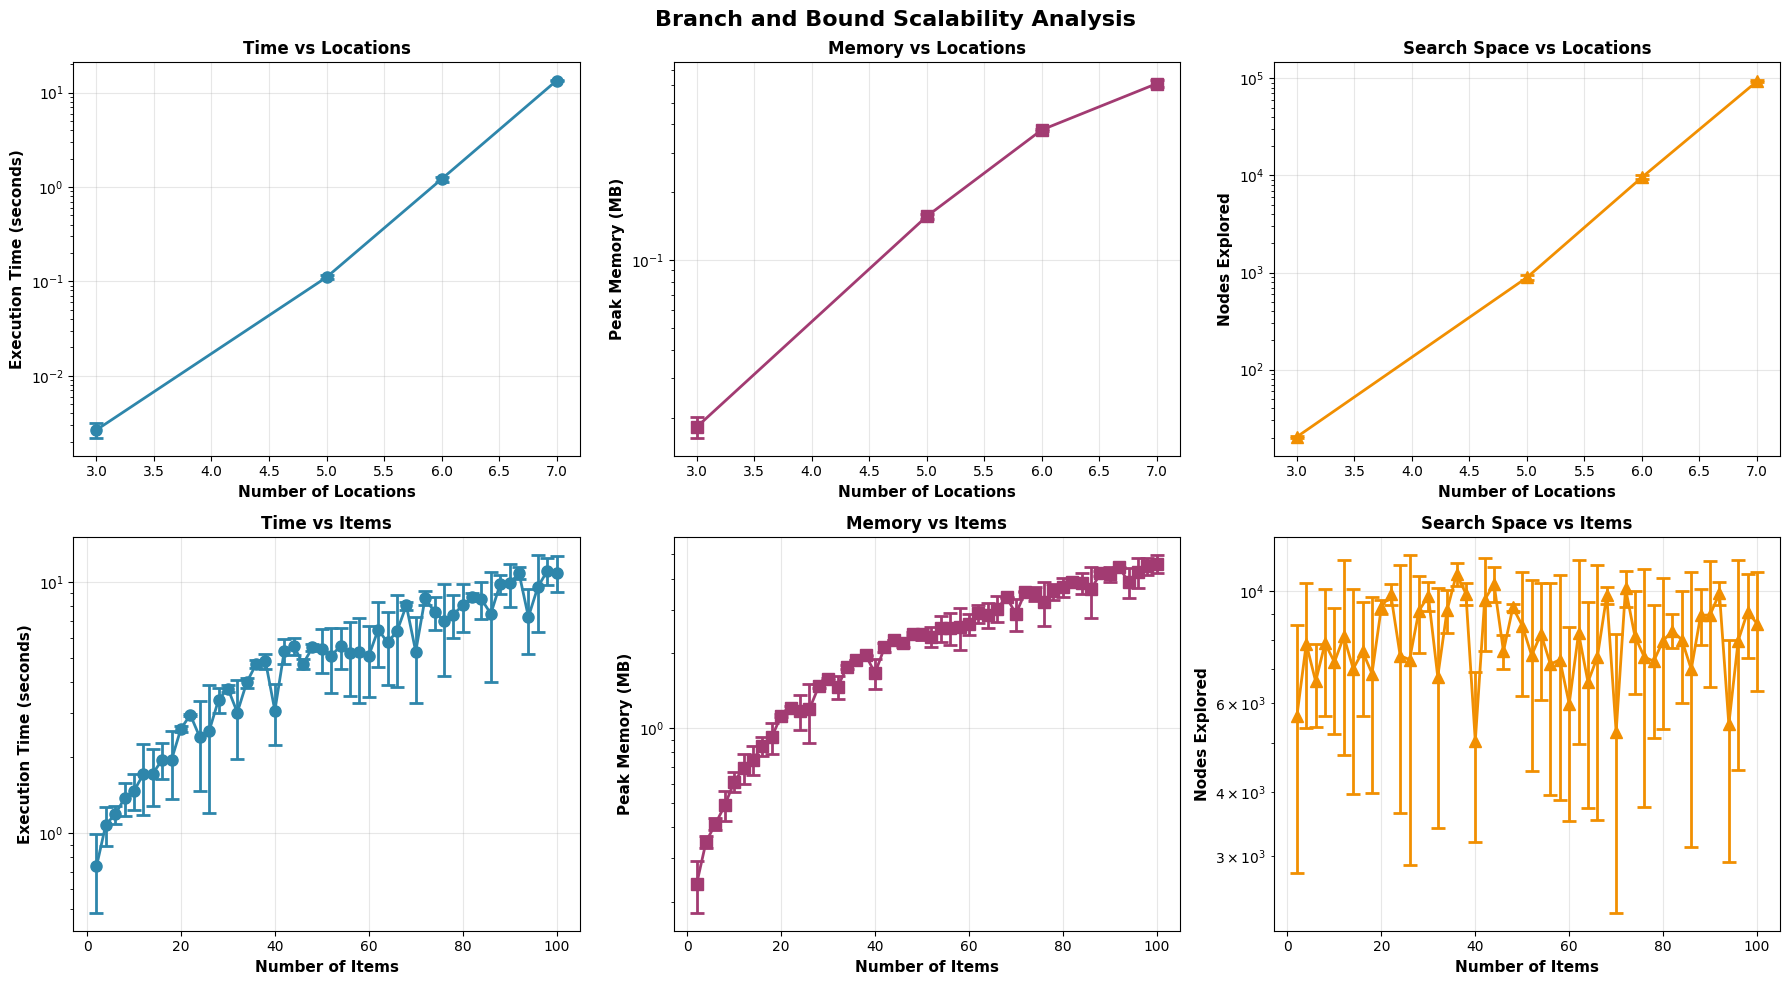

✓ Visualizations generated!


: 

In [ ]:
print("\nGenerating visualizations...")

plot_scalability_results(
    results_locations=results_locations,
    results_items=results_items,
    save_path='scalability_analysis21.png'  # save to file
)

print("✓ Visualizations generated!")